In [2]:
#tensorflow_version 2.x
import json
import requests
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, LSTM
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.metrics import mean_absolute_error
#matplotlib inline

In [3]:
endpoint = 'https://min-api.cryptocompare.com/data/histoday'
res = requests.get(endpoint + '?fsym=BTC&tsym=CAD&limit=2000')
print(res)
hist = pd.DataFrame(json.loads(res.content)['Data'])
'''
predictive = {"time":[]}
for i in range(100):
    predictive["time"].append(hist["time"][2000] + (i+1)*86400)
    
predictive = pd.DataFrame(predictive)
print(predictive)
hist = pd.concat([hist,predictive],ignore_index = True)
print(hist)
'''
hist = hist.set_index('time')
hist.index = pd.to_datetime(hist.index, unit='s')
target_col = 'close'

<Response [200]>


In [4]:
print(hist)

                high       low      open  volumefrom    volumeto     close  \
time                                                                         
2017-09-09   5679.84   5357.94   5679.84      440.17  2400710.76   5491.58   
2017-09-10   5492.28   5142.90   5491.58      775.26  4123768.95   5351.42   
2017-09-11   5436.99   5210.52   5351.42      591.76  3135539.49   5289.03   
2017-09-12   5468.19   5207.47   5289.03      704.71  3747790.10   5233.51   
2017-09-13   5305.66   4853.89   5233.51     1478.10  7429071.14   4982.82   
...              ...       ...       ...         ...         ...       ...   
2023-02-26  32198.13  31409.13  31542.40       48.99  1554088.67  32014.06   
2023-02-27  32414.07  31459.63  32014.06       73.08  2329348.39  31890.81   
2023-02-28  32083.25  31435.88  31890.81       77.81  2475149.21  31541.25   
2023-03-01  32832.70  31463.58  31541.25       98.50  3163952.33  32125.12   
2023-03-02  32315.95  31774.40  32125.12       18.73   598553.52

In [5]:
hist.drop(["conversionType", "conversionSymbol"], axis = 'columns', inplace = True)

In [6]:
def train_test_split(df, test_size=0.2):
    split_row = len(df) - int(test_size * len(df))
    train_data = df.iloc[:split_row]
    test_data = df.iloc[split_row:]
    return train_data, test_data

In [7]:
train, test = train_test_split(hist, test_size=0.1)

In [8]:
train

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2017-09-09,5679.84,5357.94,5679.84,440.17,2400710.76,5491.58
2017-09-10,5492.28,5142.90,5491.58,775.26,4123768.95,5351.42
2017-09-11,5436.99,5210.52,5351.42,591.76,3135539.49,5289.03
2017-09-12,5468.19,5207.47,5289.03,704.71,3747790.10,5233.51
2017-09-13,5305.66,4853.89,5233.51,1478.10,7429071.14,4982.82
...,...,...,...,...,...,...
2022-08-10,30996.78,29260.70,29833.82,168.04,5079627.37,30559.19
2022-08-11,31752.09,30512.52,30559.19,110.87,3454334.80,30594.59
2022-08-12,31245.77,30219.04,30594.59,68.26,2089715.54,31221.84


In [9]:
test

,high,low,open,volumefrom,volumeto,close
time,,,,,,
2022-08-15,32186.75,30717.06,31074.45,99.81,3113486.85,31138.30
2022-08-16,31288.21,30494.96,31138.30,80.67,2486416.40,30644.15
2022-08-17,31384.29,29950.53,30644.15,103.47,3160067.80,30161.69
2022-08-18,30418.14,29994.76,30161.69,104.48,3163566.26,30055.79
2022-08-19,30055.79,27057.85,30055.79,141.93,4014583.45,27080.52
...,...,...,...,...,...,...
2023-02-26,32198.13,31409.13,31542.40,48.99,1554088.67,32014.06
2023-02-27,32414.07,31459.63,32014.06,73.08,2329348.39,31890.81
2023-02-28,32083.25,31435.88,31890.81,77.81,2475149.21,31541.25


In [10]:
def line_plot(line1, line2, label1=None, label2=None, title='', lw=2):
    fig, ax = plt.subplots(1, figsize=(13, 7))
    ax.plot(line1, label=label1, linewidth=lw)
    ax.plot(line2, label=label2, linewidth=lw)
    ax.set_ylabel('price [CAD]', fontsize=14)
    ax.set_title(title, fontsize=16)
    ax.legend(loc='best', fontsize=16);

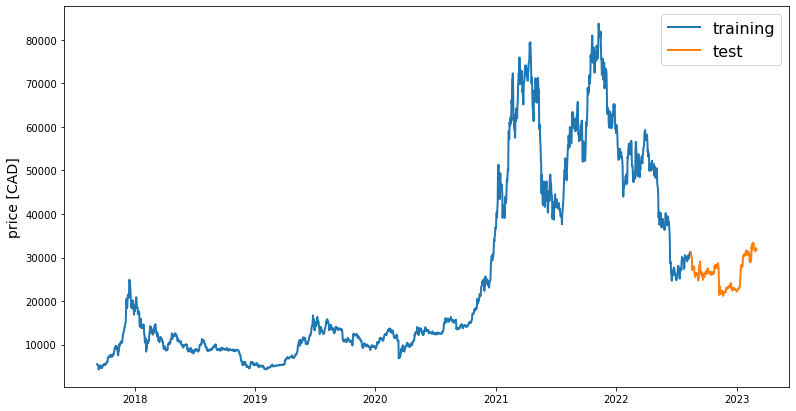

In [11]:
line_plot(train[target_col], test[target_col], 'training', 'test', title='')

In [12]:
def normalise_zero_base(df):
    return df / df.iloc[0] - 1

def normalise_min_max(df):
    return (df - df.min()) / (data.max() - df.min())

In [13]:
def extract_window_data(df, window_len=5, zero_base=True):
    window_data = []
    for idx in range(len(df) - window_len):
        tmp = df[idx: (idx + window_len)].copy()
        if zero_base:
            tmp = normalise_zero_base(tmp)
        window_data.append(tmp.values)
    return np.array(window_data)

In [14]:
def prepare_data(df, target_col, window_len=10, zero_base=True, test_size=0.1):
    train_data, test_data = train_test_split(df, test_size=test_size)
    X_train = extract_window_data(train_data, window_len, zero_base)
    
    X_test = extract_window_data(test_data, window_len, zero_base)
    y_train = train_data[target_col][window_len:].values
    y_test = test_data[target_col][window_len:].values
    if zero_base:
        y_train = y_train / train_data[target_col][:-window_len].values - 1
        y_test = y_test / test_data[target_col][:-window_len].values - 1

    return train_data, test_data, X_train, X_test, y_train, y_test

In [15]:
def build_lstm_model(input_data, output_size, neurons=300, activ_func='linear',
                     dropout=0.2, loss='mse', optimizer='adam'):
    model = Sequential()
    model.add(LSTM(neurons, input_shape=(input_data.shape[1], input_data.shape[2])))
    model.add(Dropout(dropout))
    model.add(Dense(units=output_size))
    model.add(Activation(activ_func))

    model.compile(loss=loss, optimizer=optimizer)
    return model

In [16]:
np.random.seed(42)
window_len = 5
test_size = 0.1
zero_base = True
lstm_neurons = 300
epochs = 50
batch_size = 36
loss = 'mse'
dropout = 0.2
optimizer = 'adam'

In [17]:
train, test, X_train, X_test, y_train, y_test = prepare_data(hist, target_col, window_len=window_len, zero_base=zero_base, test_size=test_size)

In [18]:
print(X_test)
model = build_lstm_model(X_train, output_size=1, neurons=lstm_neurons, dropout=dropout, loss=loss,optimizer=optimizer)
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=epochs, batch_size=batch_size, verbose=1, shuffle=True)
print(type(model))
print(type(history))
print(type(history.history))

[[[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [-2.79164563e-02 -7.23050969e-03  2.05474272e-03 -1.91764352e-01
   -2.01404560e-01 -1.58695240e-02]
  [-2.49313770e-02 -2.49545367e-02 -1.38473891e-02  3.66696724e-02
    1.49610235e-02 -3.13636261e-02]
  [-5.49483871e-02 -2.35146202e-02 -2.93733276e-02  4.67888989e-02
    1.60846705e-02 -3.47645825e-02]
  [-6.62061252e-02 -1.19126310e-01 -3.27812721e-02  4.22001803e-01
    2.89417185e-01 -1.30314757e-01]]

 [[ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
    0.00000000e+00  0.00000000e+00]
  [ 3.07080526e-03 -1.78531141e-02 -1.58695240e-02  2.82632949e-01
    2.70932656e-01 -1.57439511e-02]
  [-2.78082383e-02 -1.64027105e-02 -3.13636261e-02  2.95153093e-01
    2.72339685e-01 -1.91997494e-02]
  [-3.93892779e-02 -1.12710756e-01 -3.47645825e-02  7.59390108e-01
    6.14606246e-01 -1.16290711e-01]
  [-1.13137185e-01 -1.12946861e-01 -1.30314757e-01 -2.37510847e-01
   -

50/50 [==============================] - 1s 17ms/step - loss: 0.0017 - val_loss: 7.2224e-04
<class 'keras.engine.sequential.Sequential'>
<class 'keras.callbacks.History'>
<class 'dict'>


In [19]:
print(history)

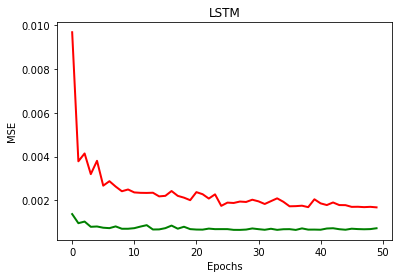

In [20]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'],'r',linewidth=2, label='Train loss')
plt.plot(history.history['val_loss'], 'g',linewidth=2, label='Validation loss')
plt.title('LSTM')
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.show()

In [21]:
targets = test[target_col][window_len:]
preds = model.predict(X_test).squeeze()
mean_absolute_error(preds, y_test)
print(type(targets))
print(preds.shape)
print(y_test)
mean_absolute_error(preds, y_test)

7/7 [==============================] - 0s 7ms/step
<class 'pandas.core.series.Series'>
(195,)
[-0.11718206 -0.08706295 -0.07513206 -0.07206898  0.02457117  0.01611636
 -0.05636474 -0.06337635 -0.08450575 -0.04806472 -0.07304042 -0.00137504
  0.01217101  0.02758015 -0.01385035  0.01490483 -0.01430679 -0.06545951
 -0.03428662 -0.02882959  0.06083674  0.08823036  0.1489176   0.14702567
  0.05021389 -0.04547209 -0.07682069 -0.0759786  -0.08212096 -0.03193243
 -0.02701541 -0.03336142 -0.05148116 -0.02062897  0.01893654 -0.00627878
  0.01105834  0.05761403  0.00278652  0.0066958   0.04060932  0.05254108
  0.01337809  0.00048056  0.01264408  0.0251731   0.02085283  0.02816168
  0.02350258 -0.00166845 -0.02783844 -0.03891538 -0.04245236 -0.01461688
 -0.00066932 -0.00397414  0.00204342 -0.01085656  0.0114715  -0.00553149
 -0.00949524 -0.00709837  0.00645977 -0.02080048  0.00553584  0.00486854
  0.0419124   0.07602857  0.05146522  0.05406006  0.07087744  0.02831823
 -0.0079833   0.01346368 -0.01

0.018081147806179493

In [22]:
from sklearn.metrics import mean_squared_error
MAE=mean_squared_error(preds, y_test)
MAE

0.000722241667195465

In [23]:
from sklearn.metrics import r2_score
R2=r2_score(y_test, preds)
R2

0.8109464352325201

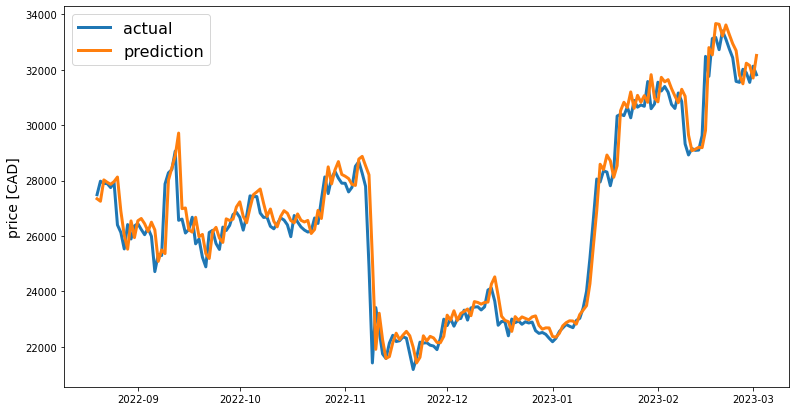

In [24]:
preds = test[target_col].values[:-window_len] * (preds + 1)
preds = pd.Series(index=targets.index, data=preds)
line_plot(targets, preds, 'actual', 'prediction', lw=3)

In [25]:
def predict_here(model , recentBatch , number):
    #recent batch contains the last 5 data ponts of hist
    
    recentBatch
    predictive = recentBatch[:]
    while(number>0):
        
        to_predict = extract_window_data(predictive[-window_len:], window_len, zero_base)
        print(to_predict)
        predicted = model.predict(to_predict).squeeze()
        predictive.append(predicted)
        
        number-=1
    
    return predictive
    
    

In [26]:
# MODEL takes input in the format schema(195,5,6)

recentBatch = y_test[-window_len:]
print(recentBatch)
predicted = model.predict([X_test[-1:]])
print(predicted[0])
recentBatch = np.concatenate([np.array(recentBatch), np.array(predicted[0])])
print(recentBatch)                   
print(extract_window_data(recentBatch, window_len, zero_base=False))
#print(predict_here(model, recentBatch , window_len , zero_base = false , 50))

[-0.03279383 -0.02619378 -0.02739048  0.01738656  0.00870479]
1/1 [==============================] - 0s 404ms/step
[0.03077354]
[-0.03279383 -0.02619378 -0.02739048  0.01738656  0.00870479  0.03077354]


AttributeError: 'numpy.ndarray' object has no attribute 'values'